In [1]:
import numpy as np
import numpy.random as rnd
from scipy.stats import linregress
from itertools import product
from skimage.util.shape import view_as_blocks
import matplotlib.pyplot as plt
import matplotlib.colors as col
import math
import random
colors = ["#222233","#F7FF00","#0099CC"]
cmap1 = col.LinearSegmentedColormap.from_list("mycmap", colors)

In [2]:
def Plot(Ma): #plotea la matriz
    plt.style.use('default')
    plt.figure(figsize = (6,6))
    plt.imshow(Ma,cmap=cmap1,vmin=0,vmax=2 ,interpolation='nearest')
    plt.show() 

def GetNumbers(A,D,tol,N): #crea el array Nk
    if ((N & (N-1) == 0) and N != 0):
        s=int(math.log2(N//2))
        if (2**(s*D)<A) and (N*N*2**(s*(D-2))>A):
            Check=True
            dd=0
            extratol=0
            while Check:
                Nu=[int(np.random.poisson(lam=A*2**(-i*D))) for i in range(s+1)]
                Nu[0]=A
                dd+=1
                if (Nu[s]>1) and (Nu[s]<=4):
                    Check=False
                    NNU=[-math.log2(Nu[i]+(Nu[i]==0)) for i in range(len(Nu))]
                    Stats=linregress(np.linspace(0,s,s+1), NNU)
                    if abs(D-Stats[0])>tol+extratol:
                        Check=True
                else:
                    Check=True
                for i in range(s):
                    if (Nu[i]<Nu[i+1]) or (Nu[i]>=4*Nu[i+1]):
                        Check=True
                    elif (dd>1000):
                        extratol=extratol+0.01
                        dd=0
            return Nu,Stats[0]

        else:
            raise Exception("No se puede encontrar condición inicial para esa Área y Dimensión")
    else:
        raise Exception("El tamaño debe ser potencia de 2")
        
def MinMax(D,N): #Me da Amin y Amax dada una dimensión D
    s=int(math.log2(N//2))
    #print([2**(s*D),N*N*2**(s*(D-2))])
    return [2**(s*D),N*N*2**(s*(D-2))]

def aMinMax(A,N): #Me da Dmin y Dmax dada un área A
    s=int(math.log2(N//2))
    #print([2.0+math.log2(A/N/N)/s,math.log2(A)/s])
    return [2.0+math.log2(A/N/N)/s,math.log2(A)/s]
    
def Ocuppation(Ma,k,N): #Devuelve N(k) de la matriz Ma
    Lar=N//k
    Cant=N//(2**k)
    B = view_as_blocks(Ma, block_shape=(Cant, Cant))
    Ocup = [np.unique(B[i][j]) for i,j in product(range(len(B)), range(len(B)))]
    O = 0
    for i in range(len(Ocup)):
        if (not np.all(Ocup[i])):
            O=O+1
    return O

def Count2(Ma):
    Celestes=0
    Amarillos=0
    Apaticos=0
    for i in range(len(Ma)):
        for j in range(len(Ma)):
            if Ma[i,j]!=0:
                if Ma[i,j]==1:
                    Amarillos+=1
                if Ma[i,j]==2:
                    Celestes+=1
            else:
                Apaticos+=1
    print("Cel=",Celestes,"Ama=",Amarillos,"Apatics=",Apaticos,"Counted=",Celestes+Amarillos+Apaticos,"L*L=",len(Ma)*len(Ma))
    
def get_inv_dict(dict0):
    '''
    invert choices dictionary i-> (x,y) yo (x,y) -> i        
    '''
    inv_dict = {}
    for item in dict0:
        inv_dict[(dict0[item][0],dict0[item][1])] = item

    return inv_dict
def Reverse(lst):
    new_lst = lst[::-1]
    return new_lst

In [3]:
def get_structured(Area,L,Numbers):
    LogL = int(np.log2(L))
    ratio = int(L/2)
    
    #initialize grid where i can throw pixels into. Starts as a 2x2 matrix
    target_grid = np.ones((2,2))
    #make target grid as a dictionary, for convenience
    target_grid_dict = {}
    target_grid_list = []
    idx = 0      #some sort of mute index
    li = 2       #size of the target grid

    for i in range (li): #agregamos a las listas
        for j in range (li):
            target_grid_dict[idx] = [i*ratio,j*ratio]
            target_grid_list.append(idx)
            idx+=1
            
    for it in range(1,len(Numbers)):

        if it==LogL: break

        Npixels = Numbers[it] - Numbers[it-1]     #new pixels to generate in this iteration
        #select areas where pixels will be thrown
        #print("antes",len(target_grid_list),Numbers[it])
        area_choices = rnd.choice(target_grid_list,Numbers[it], replace = False)

        #remove pixelless sections
        for item in target_grid_list:
            if item not in area_choices:
                target_grid_dict.pop(item)

        #print("despues:",len(target_grid_list),Numbers[it])
        dict0 = target_grid_dict  #save old dict.
        
        #update target grid
        dict1 = {}  
        count = 0
        new_ratio = int(ratio/2)    #uptade ratio
        li *= 2       #update target area box size 

        for ii in range (li):
            for jj in range(li):
                for item in target_grid_dict:
                    if ii*new_ratio >= target_grid_dict[item][0] and ii*new_ratio< target_grid_dict[item][0] + ratio and jj*new_ratio >= target_grid_dict[item][1] and jj*new_ratio< target_grid_dict[item][1] + ratio:
                        dict1.update({count: [ii*new_ratio,jj*new_ratio]})
                        count += 1
        target_grid_list = [i for i in range(count)]   #actual list to choose from
        target_grid_dict = dict1
        ratio = new_ratio       #update ratio

    # get inverse grid dict. Will be useful later    
    inv_target_grid_dict = get_inv_dict(target_grid_dict)
    grid = np.zeros((L,L),dtype=int)  #initialize grid

    #place one pixel in each box of the Nth-1 boxes    
    for item in dict0:
        dum_dict = {}
        dum_list = []
        count = 0
        for i in range (2):
            for j in range(2):
                dum_dict[count] = [dict0[item][0]+i , dict0[item][1]+j]
                dum_list.append(count)
                count+=1
        pixel = rnd.choice(dum_list)

        grid[dum_dict[pixel][0] , dum_dict[pixel][1]] = 1   #place pixel

        #use inv dict to know wich pixel hast been selected already
        sel_px = inv_target_grid_dict[dum_dict[pixel][0], dum_dict[pixel][1]]
        target_grid_list.remove(sel_px)    #remove from pool choices

    # place the rest of the pixels
    pixel_choices = rnd.choice(target_grid_list,Numbers[-1] - Numbers[-2], replace = False)
    for pixel in pixel_choices:
        grid[target_grid_dict[pixel][0],target_grid_dict[pixel][1]] = 1
        
    return grid

In [4]:
def get_two_structured(AreaA,AreaC,L,NumbersA,NumbersB):
    Tries=1
    Failed=True
    LogL = int(np.log2(L))
    ratio = int(L/2)
    while Failed:
        Failed=False
        # initialize grid where i can throw pixels into. Starts as a 2x2 matrix
        target_gridA = np.ones((2,2))
        target_gridB = np.ones((2,2))
        # make target grid as a dictionary, for convenience
        target_grid_dictA = {}
        target_grid_listA = []
        target_grid_dictB = {}
        target_grid_listB = []
        idx = 0      # some sort of mute index
        li = 2       # size of the target grid

        for i in range (li): # agregamos a las listas
            for j in range (li):
                target_grid_dictA[idx] = [i*ratio,j*ratio]
                target_grid_listA.append(idx)
                target_grid_dictB[idx] = [i*ratio,j*ratio]
                target_grid_listB.append(idx)
                idx+=1

        for it in range(1,len(NumbersA)):

            if it==LogL: break

            NpixelsA = NumbersA[it] - NumbersA[it-1]     # new pixels to generate in this iteration
            NpixelsB = NumbersB[it] - NumbersB[it-1]     # new pixels to generate in this iteration
            # select areas where pixels will be thrown
            #print("antes A",len(target_grid_listA),NumbersA[it])
            area_choicesA = rnd.choice(target_grid_listA,NumbersA[it], replace = False)
            #print("antes B",len(target_grid_listB),NumbersB[it])
            area_choicesB = rnd.choice(target_grid_listB,NumbersB[it], replace = False)
            # remove pixelless sections
            for item in target_grid_listA:
                if item not in area_choicesA:
                    target_grid_dictA.pop(item)
            for item in target_grid_listB:
                if item not in area_choicesB:
                    target_grid_dictB.pop(item)

            #print("despues A:",len(target_grid_listA),NumbersA[it])
            dict0A = target_grid_dictA  #save old dict.
            #print("despues B:",len(target_grid_listB),NumbersB[it])
            dict0B = target_grid_dictB

            # update target grid
            dict1A = {}  
            dict1B = {} 
            countA = 0
            countB = 0
            new_ratio = int(ratio/2)    # uptade ratio
            li *= 2       # update target area box size 

            for ii in range (li):
                for jj in range(li):
                    for item in target_grid_dictA:
                        if ii*new_ratio >= target_grid_dictA[item][0] and ii*new_ratio< target_grid_dictA[item][0] + ratio and jj*new_ratio >= target_grid_dictA[item][1] and jj*new_ratio< target_grid_dictA[item][1] + ratio:
                            dict1A.update({countA: [ii*new_ratio,jj*new_ratio]})
                            countA += 1
                    for item in target_grid_dictB:
                        if ii*new_ratio >= target_grid_dictB[item][0] and ii*new_ratio< target_grid_dictB[item][0] + ratio and jj*new_ratio >= target_grid_dictB[item][1] and jj*new_ratio< target_grid_dictB[item][1] + ratio:
                            dict1B.update({countB: [ii*new_ratio,jj*new_ratio]})
                            countB += 1

            target_grid_listA = [i for i in range(countA)]   # actual list to choose from
            target_grid_dictA = dict1A
            target_grid_listB = [i for i in range(countB)]   # actual list to choose from
            target_grid_dictB = dict1B
            ratio = new_ratio       # update ratio


        # get inverse grid dict. Will be useful later    
        inv_target_grid_dictA = get_inv_dict(target_grid_dictA)
        inv_target_grid_dictB = get_inv_dict(target_grid_dictB)
        grid = np.zeros((L,L),dtype=int)  #initialize grid

        # place one pixel in each box of the Nth-1 boxes    
        for item in dict0A:
            dum_dict = {}
            dum_list = []
            count = 0
            for i in range (2):
                for j in range(2):
                    dum_dict[count] = [dict0A[item][0]+i , dict0A[item][1]+j]
                    dum_list.append(count)
                    count+=1
            pixel = rnd.choice(dum_list)

            grid[dum_dict[pixel][0] , dum_dict[pixel][1]] = 1   # place pixel

            # use inv dict to know wich pixel hast been selected already
            sel_px = inv_target_grid_dictA[dum_dict[pixel][0], dum_dict[pixel][1]]
            target_grid_listA.remove(sel_px) #remove from pool choices
            try:
                sel_pxx = inv_target_grid_dictB[dum_dict[pixel][0], dum_dict[pixel][1]]
                target_grid_listB.remove(sel_pxx) # also remove from the other list if it's there
            except KeyError:
                pass

        for item in dict0B:
            dum_dict = {}
            dum_list = []
            count = 0
            for i in range (2):
                for j in range(2):
                    dum_dict[count] = [dict0B[item][0]+i , dict0B[item][1]+j]
                    dum_list.append(count)
                    count+=1
            pixel = rnd.choice(dum_list)

            # this is new, it prevents from overwriting the other pattern
            while(grid[dum_dict[pixel][0] , dum_dict[pixel][1]] == 1): 
                pixel = rnd.choice(dum_list)

            grid[dum_dict[pixel][0] , dum_dict[pixel][1]] = 2   # place pixel

            # use inv dict to know wich pixel hast been selected already
            sel_px = inv_target_grid_dictB[dum_dict[pixel][0], dum_dict[pixel][1]]
            target_grid_listB.remove(sel_px) # remove from pool choices
            try:
                sel_pxx = inv_target_grid_dictA[dum_dict[pixel][0], dum_dict[pixel][1]]
                target_grid_listA.remove(sel_pxx) # also remove from the other list if it's there
            except KeyError:
                pass

        # place the rest of the pixels, first, as usual...
        try:
            pixel_choices = rnd.choice(target_grid_listA,NumbersA[-1] - NumbersA[-2], replace = False)
        except ValueError:
            Tries=Tries+1
            Failed=True
        for pixel in pixel_choices:
            grid[target_grid_dictA[pixel][0],target_grid_dictA[pixel][1]] = 1

        # then we need to brute force it...
        TryManyB=NumbersB[-1] - NumbersB[-2] # how many left
        while(TryManyB>0):
            trying=0
            pixel=rnd.choice(target_grid_listB, replace = False)
            while(grid[target_grid_dictB[pixel][0] , target_grid_dictB[pixel][1]] != 0): 
                pixel = rnd.choice(target_grid_listB, replace = False)
                trying+=1
                '''If the following condition meets, one should redoo the whole process from scratch!'''
                if (trying>100*L):
                    Tries=Tries+1
                    Failed=True
                    break
            grid[target_grid_dictB[pixel][0],target_grid_dictB[pixel][1]] = 2
            TryManyB=TryManyB-1
            
    return Tries,grid

In [6]:
%%time
AreaA=614 #area del patron
AreaC=614
N=64 #tamaño de la grilla
NuA,dimA = GetNumbers(AreaA,1.65,0.02,N) #Nk amarillo
NuC,dimC = GetNumbers(AreaC,1.49,0.02,N) #Nk celeste
print(NuA,NuC)

[614, 190, 57, 18, 7, 2] [614, 245, 67, 38, 11, 3]
CPU times: total: 31.2 ms
Wall time: 36 ms


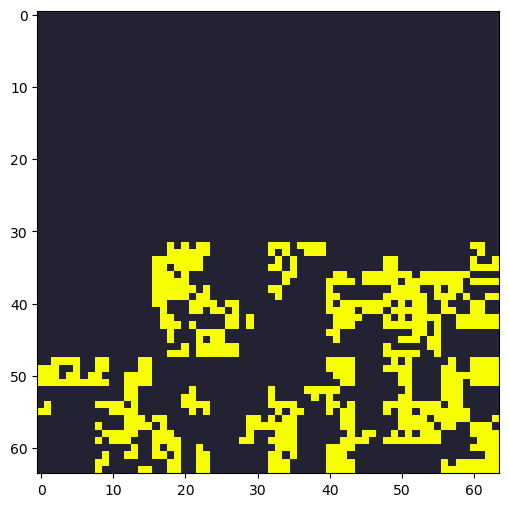

In [14]:
NuA_=NuA.copy()
NuA_.append(0)
Nua=Reverse(NuA_)
M=get_structured(AreaA,N,Nua)
Plot(M)

In [15]:
NkA=[Ocuppation(M-1,7-i,N) for i in range(1,7)]
print("Deseado:", NuA)
print("Medido:", NkA)
Count2(M)

Deseado: [614, 199, 68, 25, 7, 2]
Medido: [614, 199, 68, 24, 7, 2]
Cel= 0 Ama= 614 Apatics= 3482 Counted= 4096 L*L= 4096


Intentos= 1


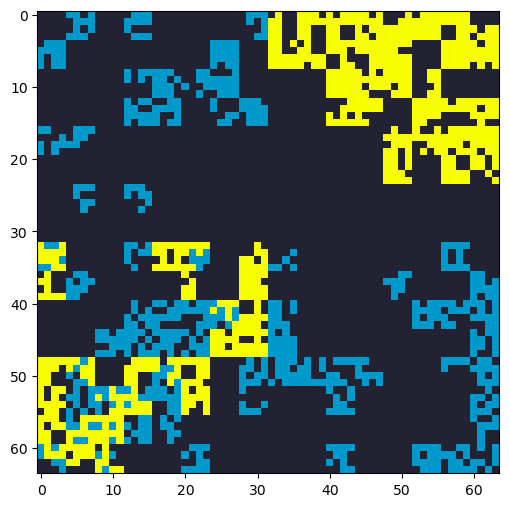

CPU times: total: 594 ms
Wall time: 594 ms


In [15]:
%%time
NuA_=NuA.copy()
NuA_.append(0)
Nua=Reverse(NuA_)
NuC_=NuC.copy()
NuC_.append(0)
Nuc=Reverse(NuC_)
Tries,M=get_two_structured(AreaA,AreaC,N,Nua,Nuc)
print("Intentos=",Tries)
Plot(M)

In [13]:
NkA=[Ocuppation(M-1,7-i,N) for i in range(1,7)]
NkC=[Ocuppation(M-2,7-i,N) for i in range(1,7)]
print("Deseado:", NuA,NuC)
print("Medido:", NkA,NkC)
Count2(M)

Deseado: [614, 190, 57, 18, 7, 2] [614, 245, 67, 38, 11, 3]
Medido: [614, 190, 57, 18, 7, 2] [614, 245, 67, 33, 11, 3]
Cel= 614 Ama= 614 Apatics= 2868 Counted= 4096 L*L= 4096
